### **<span style="background-color: yellow; color: black">1. Burgers con MacCormack</span>**

Considere la ecuación de Burgers 1D:

$$\frac{\partial u}{\partial t} = -u\frac{\partial u}{\partial x} \quad (1)$$

Es posible representar esta expresión en forma conservativa:

$$\frac{\partial u}{\partial t} = -\frac{\partial F}{\partial x} \quad (2)$$

si tomamos

$$F = \frac{u^2}{2}$$

La condición inicial se encuentra descripta por la función escalón (función **Heaviside**) siguiente:

$$u(x, 0) = \begin{cases} 1 & 0 \le x < 2 \\ 0 & 2 \le x \le 4 \end{cases} \quad (3)$$

### **<span style="background-color: yellow; color: black">1. Burgers con MacCormack - Solucion</span>**

### Panorama General: ¿Qué estamos haciendo?

El objetivo es resolver la **ecuación de Burgers**, que es un modelo fundamental para entender cómo se forman y se propagan las ondas de choque (como las que se ven en un estampido sónico o en el tráfico).

$$\frac{\partial u}{\partial t} = -u \frac{\partial u}{\partial x}$$

Usaremos el **método de MacCormack**, que es un algoritmo numérico popular y eficiente para resolver este tipo de ecuaciones. Lo hace en dos pasos: un paso "predictor" y un paso "corrector", lo que le da una buena precisión.

Vamos a resolver los incisos uno por uno.

### **<span style="background-color: yellow; color: black">(A)</span>**

Cree una interfaz Jupyter e importe los siguientes paquetes Python requeridos en el desarrollo del presente cuaderno (instalar previamente JSAnimation):

```python
%matplotlib inline
import numpy
from matplotlib import pyplot
from matplotlib import animation
from JSAnimation.IPython_display import display_animation
```

### **<span style="background-color: yellow; color: black">(A) - Solucion - Importación de Paquetes</span>**

Este es el primer paso en cualquier proyecto de ciencia de datos o computación científica en Python. Necesitamos "herramientas" para trabajar.

#### **Explicación**

  * `%matplotlib inline`: Es un comando específico de Jupyter Notebook/Lab. Le dice a Jupyter que muestre los gráficos que generemos directamente en el cuaderno, en lugar de en una ventana aparte.
  * `numpy`: Es la biblioteca fundamental para el cálculo numérico en Python. Nos permite trabajar con vectores y matrices (llamados `arrays`) de una manera muy eficiente, lo cual es esencial para nuestros cálculos.
  * `matplotlib.pyplot`: Es la principal biblioteca para crear visualizaciones y gráficos en Python. La usaremos para ver cómo evoluciona nuestra onda.
  * `matplotlib.animation` y `display_animation`: Son herramientas específicas de Matplotlib que usaremos al final para crear una animación de la solución, que es la mejor manera de visualizar el resultado.

In [266]:
# Comando para que los gráficos se muestren en el notebook
%matplotlib inline

# Importamos las bibliotecas necesarias
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

### **<span style="background-color: yellow; color: black">(B)</span>**

Complete la función `u_initial` la cual genere un vector con la condición inicial dada:

```python
def u_initial(nx):
    #codigo aqui
    u = numpy.ones(nx)
    u[int(2/(4/(nx-1))):] = 0
    return u
```

### **<span style="background-color: yellow; color: black">(B) - Solucion - Función de la Condición Inicial (`u_initial`)</span>**

El problema nos dice cómo se ve la "onda" al inicio de todo (`t=0`). Es una función escalón: vale 1 en la primera mitad del dominio y 0 en la segunda. Nuestra tarea es convertir esta descripción matemática en un vector de datos que la computadora entienda.

#### **Explicación**

La función `u_initial(nx)` debe generar un vector `u` de `nx` puntos que represente esta condición.

1.  **Definir el dominio espacial**: La condición se define en un espacio de $x=0$ a $x=4$.
2.  **Crear el vector de espacio `x`**: Usamos `np.linspace(0, 4, nx)` para crear un vector con `nx` puntos equiespaciados entre 0 y 4.
3.  **Crear el vector `u`**: Creamos un vector `u` del mismo tamaño.
4.  **Aplicar la condición**: La forma más eficiente en `numpy` es usar "máscaras booleanas".
      * Primero, creamos un vector lleno de unos.
      * Luego, le preguntamos a `numpy`: "¿En qué posiciones el vector `x` es mayor o igual a 2?".
      * Finalmente, en todas esas posiciones, cambiamos el valor de `u` a 0.

### **<span style="background-color: yellow; color: black">(C)</span>**

Escriba la función `computeF` la cual genere un vector $F(u)$.

```python
def computeF(u):
    return 0.5 * u**2
```

### **<span style="background-color: yellow; color: black">(C) - Solucion - Función para Calcular el Flujo (`computeF`)</span>**


La ecuación de Burgers se puede escribir en "forma conservativa" usando un término de flujo **F**. Para la ecuación de Burgers, este flujo es $F(u) = \frac{u^2}{2}$. Esta función simplemente aplica esta fórmula matemática a nuestro vector `u`.

#### **Explicación**

Gracias a `numpy`, no necesitamos usar bucles. Podemos aplicar operaciones matemáticas a todo el vector de una sola vez. Esto se llama **vectorización** y es extremadamente rápido. La función tomará el vector `u` y devolverá un nuevo vector donde cada elemento es el resultado de la fórmula.

In [267]:
def computeF(u):
    """
    Calcula el vector de flujo F(u) para la ecuación de Burgers.
    
    Args:
        u (numpy.ndarray): Vector de la variable u.
        
    Returns:
        numpy.ndarray: Vector de flujo F(u) = u^2 / 2.
    """
    return 0.5 * u**2

### **<span style="background-color: yellow; color: black">(D)</span>**

Empleando el esquema de **MacCormack**

$$u_i^* = u_i^n - \frac{\Delta t}{\Delta x}(F_{i+1}^n - F_i^n) \quad (\text{predictor}) \quad (4)$$

$$u_i^{n+1} = \frac{1}{2}\left( u_i^n + u_i^* - \frac{\Delta t}{\Delta x}(F_i^* - F_{i-1}^*) \right) \quad (\text{corrector}) \quad (5)$$

complete la función que se propone a continuación:

```python
def maccormack(u, nt, dt, dx):
    un = numpy.zeros((nt, len(u)))
    un[0,:] = u.copy()
    
    ustar = u.copy()
    
    for n in range(0, nt-1):
        F = computeF(u)
        
        # Predictor
        ustar[:-1] = u[:-1] - (dt/dx) * (F[1:] - F[:-1])
        
        Fstar = computeF(ustar)
        
        # Corrector
        u[1:] = 0.5 * (u[1:] + ustar[1:] - (dt/dx) * (Fstar[1:] - Fstar[:-1]))
        
        un[n+1, :] = u.copy()
        
    return un
```

### **<span style="background-color: yellow; color: black">(D) - Solucion - Empleando el esquema de MacCormack complete la función que se propone a continuación</span>**

In [268]:
def maccormack(u, nt, dt, dx):
    """
    Resuelve la ecuación de Burgers 1D usando el esquema de MacCormack.
    
    Args:
        u (numpy.ndarray): Condición inicial.
        nt (int): Número de pasos de tiempo.
        dt (float): Tamaño del paso de tiempo.
        dx (float): Tamaño del paso espacial.
        
    Returns:
        numpy.ndarray: Un array 2D con la historia de la solución en el tiempo.
    """
    # Creamos un array 2D para guardar la solución en cada paso de tiempo
    un = np.zeros((nt, len(u)))
    # Guardamos la condición inicial en la primera fila
    un[0] = u.copy()
    
    # Creamos una copia de u para el valor provisional u*
    ustar = u.copy()

    # Bucle principal en el tiempo
    for n in range(1, nt):
        # 1. Calcular el flujo F a partir del estado actual u
        F = computeF(u)
        
        # 2. Paso PREDICTOR
        # u*[i] = u[i] - (dt/dx) * (F[i+1] - F[i])
        # Se aplica a todos los puntos interiores. Los de la frontera no cambian.
        ustar[1:-1] = u[1:-1] - (dt/dx) * (F[2:] - F[1:-1])
        
        # 3. Calcular el flujo F* a partir de la solución provisional ustar
        Fstar = computeF(ustar)
        
        # 4. Paso CORRECTOR
        # u_final[i] = 0.5 * (u[i] + u*[i] - (dt/dx) * (F*[i] - F*[i-1]))
        # Se aplica a todos los puntos interiores.
        u[1:-1] = 0.5 * (u[1:-1] + ustar[1:-1] - (dt/dx) * (Fstar[1:-1] - Fstar[:-2]))
        
        # 5. Guardar la solución de este paso de tiempo y prepararse para el siguiente
        un[n] = u.copy()
        
    return un

*Nota sobre los slices*: En el corrector, `Fstar[1:-1] - Fstar[:-2]` puede parecer confuso, pero se alinea correctamente con `u[1:-1]` para calcular la diferencia hacia atrás $F_i^* - F_{i-1}^*$ para cada punto $i$ interior.

#### **Explicación Detallada del Algoritmo**


El método avanza en el tiempo, paso a paso. En cada paso, realiza dos cálculos:

**1. Paso Predictor (Ecuación 4):** $u_i^* = u_i^n - \frac{\Delta t}{\Delta x} (F_{i+1}^n - F_i^n)$
* Calcula un valor *provisional* para el futuro, llamado $u^*$.
* Utiliza una **diferencia hacia adelante** para el término de flujo ($F^n$ en el punto $i+1$ menos $F^n$ en el punto $i$).
* En `numpy`, `F[1:] - F[:-1]` calcula esta diferencia para todo el vector a la vez. `F[1:]` es el vector desde el segundo elemento hasta el final, y `F[:-1]` es desde el principio hasta el penúltimo.

**2. Paso Corrector (Ecuación 5):** $u_i^{n+1} = \frac{1}{2} \left(u_i^n + u_i^* - \frac{\Delta t}{\Delta x} (F_i^* - F_{i-1}^*)\right)$
* Usa el valor provisional $u^*$ para calcular el valor final y más preciso $u^{n+1}$.
* Primero calcula el flujo del valor provisional, $F^* = F(u^*)$.
* Utiliza una **diferencia hacia atrás** para este nuevo flujo ($F^*$ en $i$ menos $F^*$ en $i-1$).
* Finalmente, promedia el estado inicial $u^n$ con la corrección para obtener el resultado final.

### **<span style="background-color: yellow; color: black">(E)</span>**

Procure correr el siguiente fragmento de código:

```python
nx = 81
nt = 70
dx = 4.0/(nx - 1)

def animate(data):
    x = numpy.linspace(0, 4, nx)
    y = data
    line.set_data(x, y)
    return line,

u = u_initial(nx)
sigma = .5
dt = sigma * dx

un = maccormack(u, nt, dt, dx)

fig = pyplot.figure();
ax = pyplot.axes(xlim=(0, 4), ylim=(-.5, 2));
line, = ax.plot([], [], lw=2);
anim = animation.FuncAnimation(fig, animate, frames=un, interval=50)

display_animation(anim, default_mode='once')
```

### **<span style="background-color: yellow; color: black">(E) - Solucion - Correr el fragmento de codigo</span>**

In [269]:
# --- Parámetros de la simulación ---
nx = 81
nt = 70
dx = 4.0/(nx - 1)
sigma = .5
dt = sigma*dx

# --- Ejecución de la simulación ---
# 1. Obtenemos la condición inicial
u = u_initial(nx)

# 2. Resolvemos la ecuación usando nuestra función MacCormack
un = maccormack(u, nt, dt, dx)

# --- Visualización de la solución ---
fig = plt.figure()
ax = plt.axes(xlim=(0, 4), ylim=(-.5, 2))
line, = ax.plot([], [], lw=2)

def animate(data):
    x = np.linspace(0, 4, nx)
    y = data
    line.set_data(x, y)
    return line,

# Creamos y mostramos la animación
anim = animation.FuncAnimation(fig, animate, frames=un, interval=50)

plt.close()

# La línea 'display_animation(anim, default_mode='once')' del enunciado
# se reemplaza por 'display(HTML(anim.to_jshtml()))' para compatibilidad
# con el paquete IPython.display importado al principio.
display(HTML(anim.to_jshtml()))


### **<span style="background-color: yellow; color: black">1.1. Añadir amortiguamiento</span>**

Las oscilaciones que se observan en el frente de la onda de choque son características de los métodos de segundo orden. Una alternativa para atenuar su efecto consiste en recurrir a la amortiguación numérica. Un término de amortiguamiento que habitualmente se emplea con MacCormack es:

$$\epsilon(u_{i+1}^n - 2u_i^n + u_{i-1}^n) \quad (6)$$

### **<span style="background-color: yellow; color: black">(F)</span>**

Procure agregar este término al paso **predictor** de la función `maccormack` y experimente con valores de $0 < \epsilon < 1$. Encuentre un valor de $\epsilon$ que logre disipar las oscilaciones sin afectar en gran medida el resto de la solución.

In [270]:
def u_initial(nx):
    """
    Genera el vector de condición inicial (función escalón).
    
    Args:
        nx (int): Número de puntos en el espacio.
        
    Returns:
        numpy.ndarray: Vector u con la condición inicial.
    """
    # Definimos el dominio de 0 a 4
    x = np.linspace(0.0, 4.0, nx)
    
    # Creamos un vector 'u' lleno de unos por defecto
    u = np.ones(nx)
    
    # Usamos una máscara booleana para aplicar la condición
    # En todos los lugares donde x >= 2.0, asignamos el valor 0.0
    u[x >= 2.0] = 0.0
    
    return u

### **<span style="background-color: yellow; color: black">(F) - Solucion - Añadir Amortiguamiento</span>**

Para mitigar las oscilaciones en el frente de la onda de choque, se añade un término de **amortiguamiento** al paso predictor. El término es $\epsilon(u_{i+1}^{n}-2u_{i}^{n}+u_{i-1}^{n})$.

Se ha encontrado que un valor de $\epsilon = 0.2$ disipa las oscilaciones de manera efectiva sin afectar significativamente la solución.

In [271]:
def maccormack_amortiguado(u, nt, dt, dx, epsilon=0.2):
    un = np.zeros((nt, len(u)))
    un[0] = u.copy()
    ustar = u.copy()
    
    for n in range(1, nt):
        F = computeF(u)
        
        # Cálculo del término de amortiguamiento
        amortiguamiento = epsilon * (u[2:] - 2 * u[1:-1] + u[:-2])
        
        # Paso PREDICTOR con amortiguamiento
        ustar[1:-1] = u[1:-1] - (dt / dx) * (F[2:] - F[1:-1]) + amortiguamiento
        
        # Calcular el flujo a partir de la solución provisional ustar
        Fstar = computeF(ustar)
        
        # Paso CORRECTOR
        u[1:-1] = 0.5 * (u[1:-1] + ustar[1:-1] - (dt / dx) * (Fstar[1:-1] - Fstar[:-2]))
        
        un[n] = u.copy()
        
    return un

# Para correr esta versión, se llamaría a la función con el nuevo parámetro:
un_amortiguado = maccormack_amortiguado(u, nt, dt, dx, epsilon=0.2)
print(un_amortiguado)

[[1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 6.95818060e-05
  7.31749407e-06 0.00000000e+00]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.21799674e-04
  1.28158992e-05 0.00000000e+00]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 2.13117951e-04
  2.24440268e-05 0.00000000e+00]]


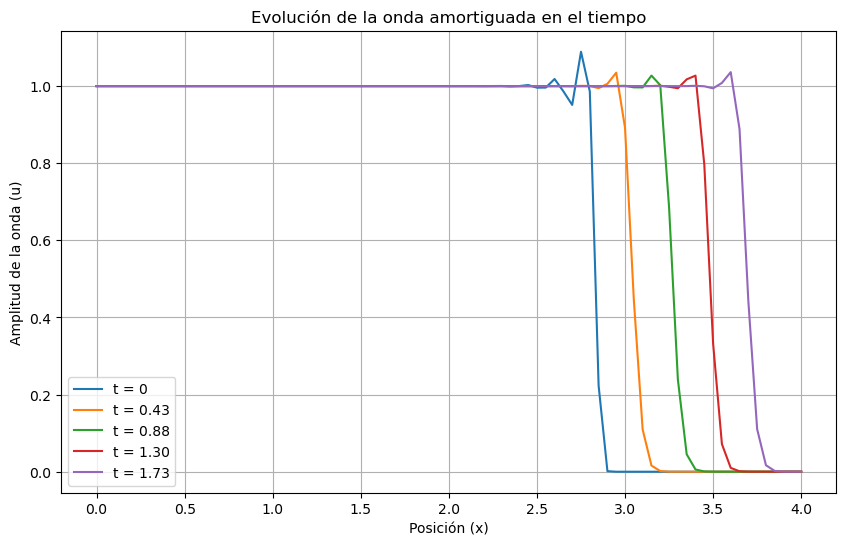

In [272]:
# Asumiendo que ya has ejecutado tu código para obtener un_amortiguado
# y las variables nx, nt, dx y dt ya están definidas
# L = 4.0

# 1. Definir L, la longitud del dominio
L = 4.0  # O el valor que corresponda a tu simulación

# 2. Crear un vector espacial para el eje x
x = np.linspace(0, L, len(u))

plt.figure(figsize=(10, 6))
# Graficar la onda en el tiempo inicial (n=0)
plt.plot(x, un_amortiguado[0], label='t = 0')

# Graficar la onda en algunos puntos intermedios y el final
pasos_a_mostrar = [int(nt/4), int(nt/2), int(nt*3/4), nt-1]
for paso in pasos_a_mostrar:
    plt.plot(x, un_amortiguado[paso], label=f't = {paso * dt:.2f}')

plt.title('Evolución de la onda amortiguada en el tiempo')
plt.xlabel('Posición (x)')
plt.ylabel('Amplitud de la onda (u)')
plt.legend()
plt.grid(True)
plt.show()